# Multi-Layer QG (Revised)

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Helmholtz Decomposition

In [6]:
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)

L = 2_000e3

xc = jnp.linspace(-L, L, nx+1)
yc = jnp.linspace(-L, L, ny+1)

xx, yy = jnp.meshgrid(xc, yc, indexing="ij")

dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

xx.shape

(257, 257)

**Helmholtz Equation**

In [17]:
from jaxsw._src.operators.functional.dst import helmholtz_dist, laplacian_dist, inverse_elliptical_dst_solver, inverse_elliptic_dst

In [3]:
def laplacian_dist(nx, ny, dx, dy, mean: bool = True) -> Array:
    if mean:
        dx = dy = jnp.mean(jnp.asarray([dx, dy]))

    x, y = jnp.meshgrid(
        jnp.arange(1, nx, dtype=dx.dtype),
        jnp.arange(1, ny, dtype=dx.dtype),
        indexing="ij"
    )

    return (
        2 * (jnp.cos(jnp.pi / nx * x) - 1) / dx**2
        + 2 * (jnp.cos(jnp.pi / ny * y) - 1) / dy**2
    )

In [4]:
def helmholtz_fn(u, dx, dy, beta):
    d2u_dx2 = (u[...,2:,1:-1] + u[...,:-2,1:-1] - 2*u[..., 1:-1,1:-1]) / dx**2
    d2u_dy2 = (u[...,1:-1,2:] + u[...,1:-1,:-2] - 2*u[...,1:-1,1:-1]) / dy**2
    return d2u_dx2 + d2u_dy2 - beta * u[..., 1:-1,1:-1]

In [7]:
beta = 1.0

H_matrix = laplacian_dist(nx, ny, dx, dy) - beta

print(H_matrix.shape, xx.shape)

(255, 255) (257, 257)


In [9]:
# create random matrix
key = jrandom.PRNGKey(42)
Frect = jnp.zeros(shape=(nx+1,ny+1))
Frect = Frect.at[1:-1,1:-1].set(jrandom.normal(key=key, shape=(nx-1,ny-1)))


Hfrect = helmholtz_fn(Frect, dx, dy, beta)
Hfrect.shape

(255, 255)

## Solve

In [15]:
import jax.numpy as jnp
from jaxtyping import Array


def dstI1D(x, norm="ortho"):
    """1D type-I discrete sine transform."""
    return jnp.fft.irfft(-1j * jnp.pad(x, (1, 1)), axis=-1, norm=norm)[
        1 : x.shape[0] + 1, 1 : x.shape[1] + 1
    ]


def dstI2D(x, norm="ortho"):
    """2D type-I discrete sine transform."""
    return dstI1D(dstI1D(x, norm=norm).T, norm=norm).T


def inverse_elliptic_dst(f, operator_dst):
    """Inverse elliptic operator (e.g. Laplace, Helmoltz)
    using float32 discrete sine transform."""
    return jnp.pad(dstI2D(dstI2D(f) / operator_dst), pad_width=((1,1),(1,1)), mode="constant", constant_values=0.0)

In [16]:
Frect_r = inverse_elliptic_dst(Frect[1:-1,1:-1], H_matrix)

In [17]:
Frect_r.shape, Frect.shape

((257, 257), (257, 257))

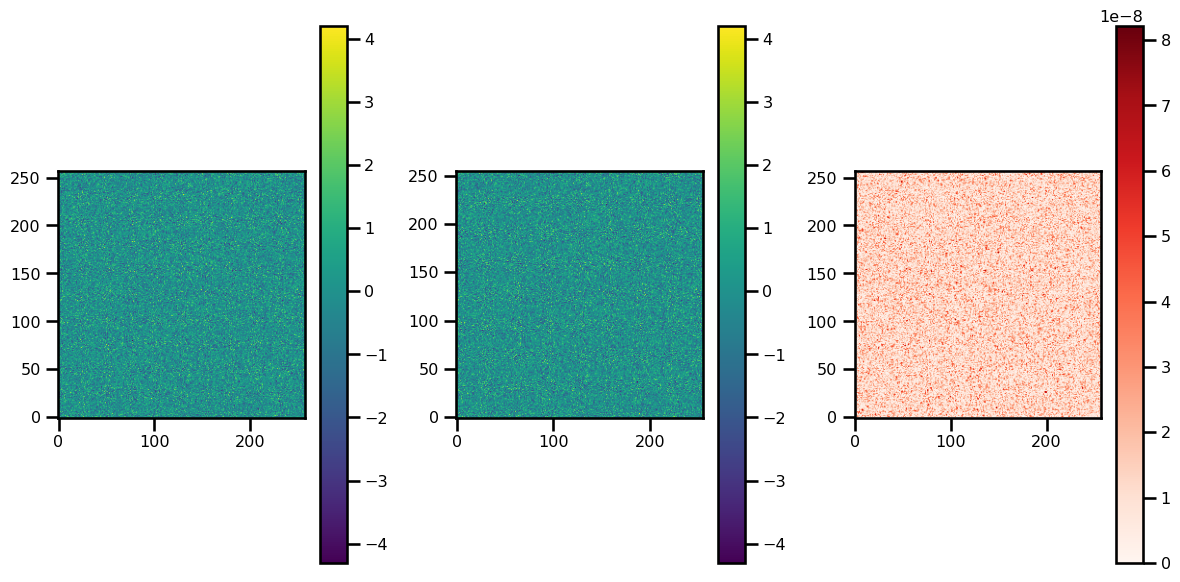

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6))

pts = ax[0].imshow(Frect.T, origin="lower")
plt.colorbar(pts)

pts = ax[1].imshow(-Frect_r[1:-1,1:-1].T, origin="lower")
plt.colorbar(pts)

pts = ax[2].imshow(np.abs(Frect - - Frect_r).T, origin="lower", cmap="Reds")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## TORCH CODE

In [25]:
import torch
import torch.nn.functional as F

def dstI1D(x, norm='ortho'):
    """1D type-I discrete sine transform."""
    return torch.fft.irfft(-1j*F.pad(x, (1,1)), dim=-1, norm=norm)[...,1:x.shape[-1]+1]


def dstI2D(x, norm='ortho'):
    """2D type-I discrete sine transform."""
    return dstI1D(dstI1D(x, norm=norm).transpose(-1,-2), norm=norm).transpose(-1,-2)


def compute_laplace_dst(nx, ny, dx, dy, arr_kwargs):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = torch.meshgrid(torch.arange(1,nx, **arr_kwargs),
                          torch.arange(1,ny, **arr_kwargs),
                          indexing='ij')
    return 2*(torch.cos(torch.pi/nx*x) - 1)/dx**2 + 2*(torch.cos(torch.pi/ny*y) - 1)/dy**2


def solve_helmholtz_dst(rhs, helmholtz_dst):
    return F.pad(dstI2D(dstI2D(rhs.type(helmholtz_dst.dtype)) / helmholtz_dst),
                 (1,1,1,1)
                ).type(torch.float64)


In [26]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 24})
plt.ion()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float64

# grid
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)
L = 2000e3
xc = torch.linspace(-L, L, nx+1, dtype=dtype, device=device)
yc = torch.linspace(-L, L, ny+1, dtype=dtype, device=device)
xx, yy = torch.meshgrid(xc, yc, indexing='ij')
dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

# Helmholtz eq.
lambd = torch.DoubleTensor(1,1,1).type(dtype).to(device)
helmholtz = lambda f, dx, dy, lambd: \
    (   (f[...,2:,1:-1] + f[...,:-2,1:-1] - 2*f[...,1:-1,1:-1])/dx**2
      + (f[...,1:-1,2:] + f[...,1:-1,:-2] - 2*f[...,1:-1,1:-1])/dy**2
      - lambd * f[...,1:-1,1:-1]
    )
helmholtz_dst = compute_laplace_dst(
        nx, ny, dx, dy, {'dtype':dtype, 'device': device}) \
        - lambd

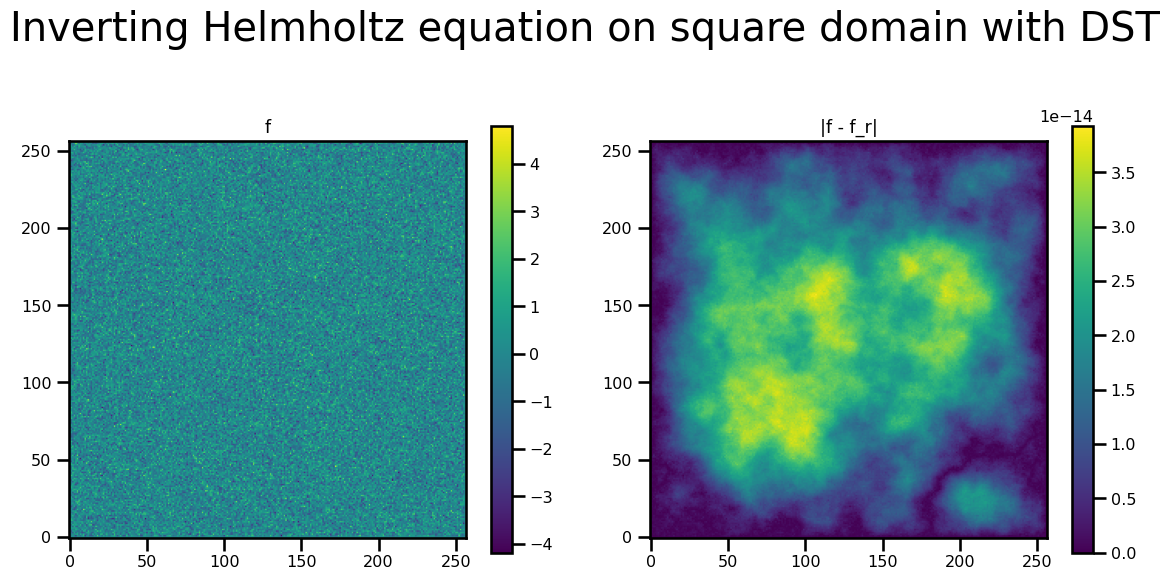

In [27]:
# Rectangular domain
frect = torch.zeros(1, nx+1, ny+1, dtype=dtype, device=device)
frect[...,1:-1,1:-1].normal_()
Hfrect = helmholtz(frect, dx, dy, lambd)
frect_r = solve_helmholtz_dst(Hfrect, helmholtz_dst)
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].set_title('f')
fig.colorbar(ax[0].imshow(frect[0].cpu().T, origin='lower'), ax=ax[0])
ax[1].set_title('|f - f_r|')
fig.colorbar(ax[1].imshow(torch.abs(frect - frect_r)[0].cpu().T, origin='lower'), ax=ax[1])
fig.suptitle('Inverting Helmholtz equation on square domain with DST')
fig.tight_layout()